# Hybrid One-Class deep SVDD - VAE


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.random import normal
import tensorflow.keras as keras

from tensorflow.keras import Model, layers
from tensorflow.keras.datasets import mnist

print(tf.__version__)

# DRIVE
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/BACMMAN_DISTNET/')

from uad.callbacks.metrics import AUCCallback, PrecisionRecallCallback
from uad.MNIST.draw_line import set_anomaly, predict_anomalies, contour_anomalies, plot_anomalies
from uad.MNIST.one_vs_all import plot_prediction, plot_per_digit_proportion
from uad.decision.reconstruction import is_anormal, decision_function, binarize_set
from uad.models.variational_autoencoder import ConvolutionalVAE
from uad.diagnostic.visualisation import plot_tSNE
from uad.diagnostic.metrics import compute_ROC, compute_AUC, plot_ROC

!nvidia-smi

2.3.0
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Tue Aug 11 12:53:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

interest_digit = 0

# x_val, y_val_bin = x_train[-1000:], binarize_set(y_train[-1000:], interest=interest_digit)

# train set sorted by digits: digits_train[i] = x_train elements where y_train == i
digits_train = np.array([x_train[np.where(y_train[:-1000] == i)] for i in range(10)])

x_val = np.concatenate((digits_train[0][:500], digits_train[1][:50], 
                        digits_train[2][:50], digits_train[3][:50],
                        digits_train[4][:50], digits_train[5][:50],
                        digits_train[6][:50], digits_train[7][:50],
                        digits_train[8][:50], digits_train[9][:100]), axis=0)
y_val_bin = np.concatenate((np.zeros(500), np.ones(500)), axis=0)

# training set contains only zeros (for training on zeros)
labels_bin = binarize_set(y_train, interest=interest_digit)
x_train_bin, y_train_bin = digits_train[interest_digit][:-500], y_train[np.where(y_train[:-500] == interest_digit)][:-500]
y_test_bin = binarize_set(y_test, interest=interest_digit)

print(x_train_bin.shape, y_train_bin.shape, x_val.shape, y_val_bin.shape)

11493376/11490434 [==============================] - 0s 0us/step
(5325, 28, 28, 1) (5377,) (1000, 28, 28, 1) (1000,)


In [48]:
from uad.models.architecture import get_unet_vae
from uad.models.variational_autoencoder import OC_VAE, Sampling

def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True, activation1="sigmoid",
                 activation2="sigmoid"):
    """Function to add 2 convolutional layers with the parameters passed to it
    activation1: name of the activation function to apply. If none, pass "" (empty string)
    activation2: name of the activation function to apply. If none, pass "" (empty string)
    """
    # first layer
    x = layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), \
                      kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    if activation1 != "":
        x = layers.Activation(activation1)(x)

    # second layer
    x = layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), \
                      kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    if activation2 != "":
        x = layers.Activation(activation2)(x)

    return x

def build_VOCAE(n_filters=16, latent_dim=16, n_contractions=3, LAMBDAS=(0.2, 0.2)):
    latent_dim = latent_dim
    latent_side = int(2 ** (5 - n_contractions))  
    batchnorm = False
    dropout = 0.2
    k_size = 3

    act1, act2, final_activation = "sigmoid", "sigmoid", "sigmoid"

    encoder_inputs = layers.Input(shape=(28, 28, 1), name="encoder_inputs")

    paddings = tf.constant([[0, 0], [2, 2], [2, 2], [0, 0]])  # shape d x 2 where d is the rank of the tensor and 2 represents "before" and "after"
    x = tf.pad(encoder_inputs, paddings, name="pad")

    for k in range(n_contractions):
        x = conv2d_block(x, n_filters * (2**k), kernel_size=k_size, batchnorm=batchnorm, 
                     activation1=act1, activation2=act2)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(dropout)(x)

    z_mean = layers.Conv2D(latent_dim, 1, strides=1, name="z_mean")(x)
    z_log_var = layers.Conv2D(latent_dim, 1, strides=1, name="z_log_var")(x)
    z = Sampling()((z_mean, z_log_var))

    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    # Define decoder model.
    latent_inputs = layers.Input(shape=(latent_side, latent_side, latent_dim), 
                                 name="z_sampling")
    x = latent_inputs
    
    for k in range(n_contractions, 0, -1):
        x = layers.Conv2DTranspose(n_filters * (2**(k - 1)), (k_size, k_size), strides=(2, 2), 
                               padding='same', name=f"u{n_contractions + k}")(x)
        x = layers.Dropout(dropout)(x)
        if k == 1:
            decoder_outputs = conv2d_block(x, 1, kernel_size=k_size, batchnorm=batchnorm, 
                              activation1=act1, activation2=act2)
        else:
            x = conv2d_block(x, n_filters * (2**(k - 1)), kernel_size=k_size, batchnorm=batchnorm, 
                              activation1=act1, activation2=act2)

    crop = tf.image.resize_with_crop_or_pad(decoder_outputs, 28, 28)

    decoder = Model(inputs=latent_inputs, outputs=crop, name="decoder")

    return OC_VAE(encoder, decoder, reconstruction_loss="xent", input_dims=(28, 28, 1), latent_dims=(latent_side, latent_side, latent_dim), LAMBDAS=LAMBDAS)

oc_vae = build_VOCAE(n_filters=16, latent_dim=8, n_contractions=3)

# print(vae.encoder.summary(), vae.decoder.summary())

In [36]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard

oc_vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

reduce_lr = ReduceLROnPlateau(
    monitor='val_reconstruction_loss', factor=0.1, patience=5, verbose=1, mode='auto',
    min_delta=0.0001, cooldown=0, min_lr=1e-8,)

import datetime, os
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

history = oc_vae.fit(x_train_bin, x_train_bin, validation_data=(x_val, y_val_bin), epochs=100, batch_size=128, callbacks=[tensorboard_callback, reduce_lr])

Epoch 1/100
42/42 [==============================] - 1s 24ms/step - loss: 152.9585 - reconstruction_loss: 366.9131 - centripetal_loss: 29.8950 - kl_loss: 0.5355 - val_loss: 112.5251 - val_reconstruction_loss: 277.9806 - val_centripetal_loss: 5.5858 - val_kl_loss: 0.5393
Epoch 2/100
42/42 [==============================] - 0s 10ms/step - loss: 116.8684 - reconstruction_loss: 290.3404 - centripetal_loss: 2.3032 - kl_loss: 0.6790 - val_loss: 89.4042 - val_reconstruction_loss: 222.1713 - val_centripetal_loss: 0.7473 - val_kl_loss: 0.9656
Epoch 3/100
42/42 [==============================] - 0s 10ms/step - loss: 97.2679 - reconstruction_loss: 241.6048 - centripetal_loss: 1.0262 - kl_loss: 1.0518 - val_loss: 92.4139 - val_reconstruction_loss: 229.4309 - val_centripetal_loss: 1.0971 - val_kl_loss: 1.0553
Epoch 4/100
42/42 [==============================] - 0s 10ms/step - loss: 94.7302 - reconstruction_loss: 235.3076 - centripetal_loss: 0.9666 - kl_loss: 1.0344 - val_loss: 90.8493 - val_reconst

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [37]:
z_means, _, _ = oc_vae.encoder.predict(x_test)

from uad.diagnostic.visualisation import compute_tSNE

projections = compute_tSNE(z_means, desired_axis=None)

t-SNE inputs shape: (10000, 128)


10
0.04333463


Text(0.5, 1.0, 'VOCAE latent space - radius = 0.04')

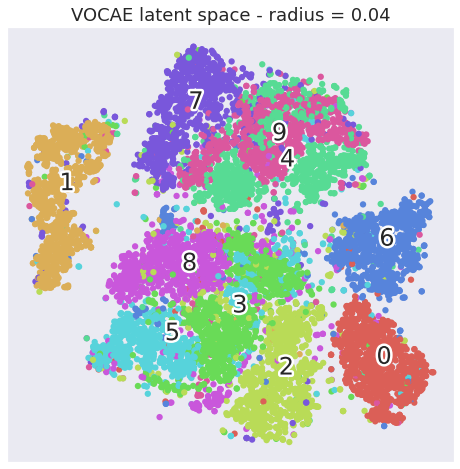

In [38]:
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import time

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123


def plot_tSNE(projections, colors, plt_ax=None):
    x = projections
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))
    #     palette = np.array(colors)

    print(num_classes)

    # create a scatter plot.
    if plt_ax is None:
        f = plt.figure(figsize=(8, 8))
        plt_ax = plt.subplot(aspect='equal')
        sc = plt_ax.scatter(x[:, 0], x[:, 1], lw=0, s=40, c=palette[colors.astype(np.int)])
        plt.xlim(-25, 25)
        plt.ylim(-25, 25)
        plt_ax.axis('on')
        plt_ax.axis('tight')
    else:
        f = None
        sc = plt_ax.scatter(x[:, 0], x[:, 1], lw=0, s=40, c=palette[colors.astype(np.int)])
        plt.xlim(-25, 25)
        plt.ylim(-25, 25)
        plt_ax.axis('on')
        plt_ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):
        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = plt_ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    plt_ax.get_xaxis().set_visible(False)
    plt_ax.get_yaxis().set_visible(False)

    return f, plt_ax, sc, txts

fig, axis, sc, txt = plot_tSNE(projections, y_test)
rad = np.max(np.sqrt(np.sum((oc_vae.CENTER - z_means) ** 2, axis=(1, 2, 3))), axis=0)
print(rad)
axis.set_title(f"VOCAE latent space - radius = {}")
# plt.savefig("/content/gdrive/My Drive/BACMMAN_DISTNET/imgs/tSNE_ocvae_rad=")

In [52]:
from uad.diagnostic.metrics import compute_AUC_on_all
from sklearn.metrics import roc_curve

n_filters, latent_dim = 16, 8
n_classes, replicas = 10, 10
epochs = 50
auc_scores = np.zeros((10, replicas))  # (digits, replicas)
LAMBDAS = (0.5, 0.)

for k in range(n_classes):  # each digit
    for i in range(replicas): # 10 replicas
        model = build_VOCAE(n_filters=n_filters, latent_dim=latent_dim, LAMBDAS=LAMBDAS)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
        model.fit(digits_train[k], digits_train[k], epochs=epochs, batch_size=128, verbose=0)
        y_test_bin = binarize_set(y_test, interest=k)
        y_score = oc_vae.score_samples(x_test, decision_function="distance")
        fpr, tpr, _ = roc_curve(y_test_bin, y_score)
        auc = oc_vae.compute_AUC(fpr, tpr)
        print(f"Digit {k}, Iteration {i}, Final AUC: {auc}")
        auc_scores[k, i] = auc

print(auc_scores)
np.save("/content/gdrive/My Drive/BACMMAN_DISTNET/models/vocae_auc_per_class_MNIST_10replicas", auc_scores)

Digit 0, Iteration 0, Final AUC: 0.6575845060862483


KeyboardInterrupt: ignored

[0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]


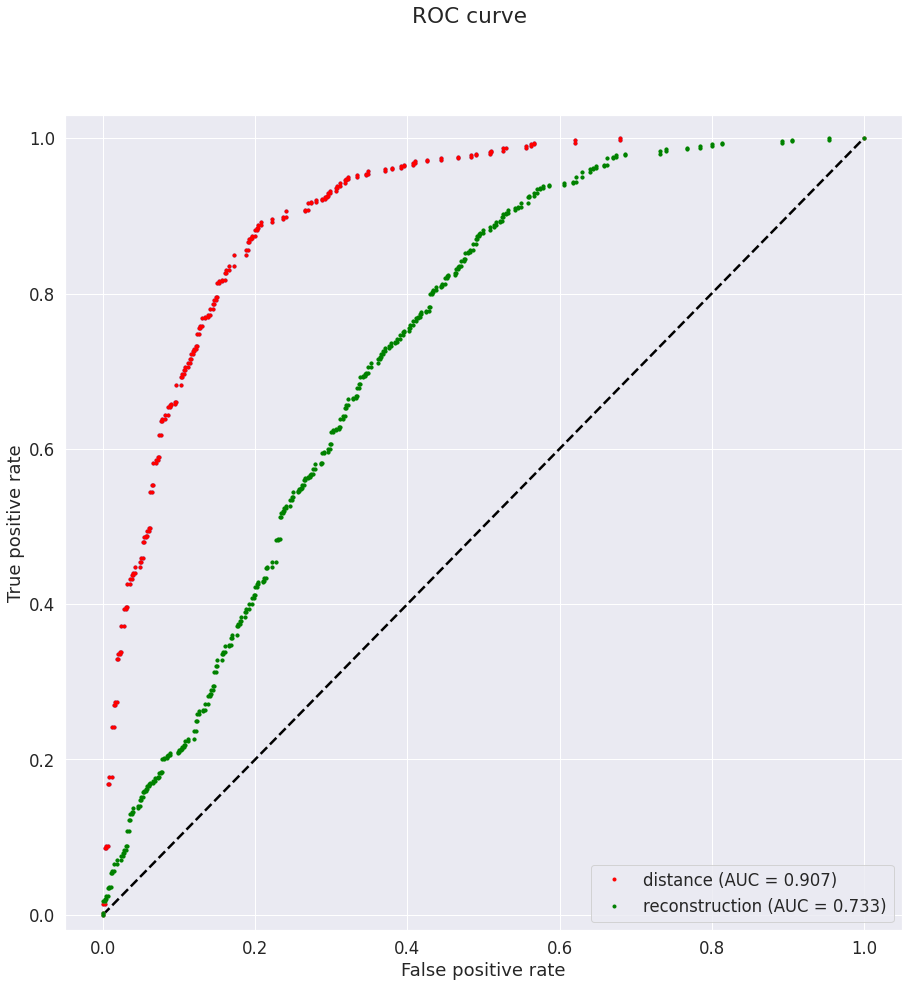

In [39]:
def anomaly_score(model, data, decision_func="distance", batch=True):
    """
    Compute the anomaly score from preidctions of model. Those predictions are considered
    to vectors
    # TODO: implement for matrix or 3-tensors predictions
    :param model: Model that has a CENTER attribute
    :param data: input data in tf format (3-tensor)
    :param decision_func: can be either "distance" to predict anomalies based on their distance to the model's center
    (in an SVDD manner) or "reconstruction" to predict anomalies based on the reconstruction error between the input
    image and the reconstruction (using MSE, in a VAE manner).
    :param batch: True if the given data is a batch
    :return: a vector of distance or a distance depending on the input data
    """
    if decision_func == "distance":
        predictions, z_log_var, _ = model.encoder.predict(data)
        if batch:
            if len(predictions.shape) == 4:  # batch of tensors along the first axis
                return tf.sqrt(tf.reduce_sum((model.CENTER - predictions) ** 2, axis=(-3, -2, -1)))
            elif len(predictions.shape) == 3:  # batch of matrices along the first axis
                return tf.sqrt(tf.reduce_sum((model.CENTER - predictions) ** 2, axis=(-2, -1)))
            elif len(predictions.shape) == 2:  # batch of vectors along the first axis
                return tf.sqrt(tf.reduce_sum((model.CENTER - predictions) ** 2, axis=-1))
        else:
            return tf.sqrt(tf.reduce_sum(model.CENTER - predictions) ** 2)

    if decision_func == "reconstruction":
        predictions = model.predict(data)
        return tf.sqrt(tf.reduce_sum((data - predictions) ** 2 , axis=(-3, -2, -1)))


def score_samples(model, data, decision_function="distance"):
    return anomaly_score(model, data, decision_func=decision_function)

from sklearn.metrics import roc_curve

def compute_ROC(y_true, y_score, pos_label=0):
    return roc_curve(y_true, y_score, pos_label=pos_label)

scores = []
fprs, tprs = [], []
decision_funcs = ["distance", "reconstruction"]
for elt in decision_funcs:
    scores.append(score_samples(oc_vae, x_val, decision_function=elt))
    fpr, tpr, _ = compute_ROC(y_val_bin, scores[-1], pos_label=1)
    fprs.append(fpr)
    tprs.append(tpr)

def plot_ROC(fpr, tpr, labels=["ROC curve"]):
    """
    Plot the ROC curves from false positives rate and true positives rate
    :param fpr: array: false positive rate
    :param tpr: array: true positive rate
    :param labels: str or list: labels to give to each curve
    :return:
    """
    if type(fpr) == list:
        fpr = np.array(fpr)
    if type(tpr) == list:
        tpr = np.array(tpr)
    if type(labels) == list:
        labels = np.array(labels)

    colours = ['r', 'g', 'b', 'm', 'y', 'k']
    symbols = ['*', '.', '-', '--', '^', 'v']
    fig, ax = plt.subplots(1, 1, figsize=(15, 15), sharex="all", sharey="all")
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
    fig.suptitle("ROC curve")
    if len(fpr.shape) == (1,): # single curve
        ax.plot(fpr, tpr, '.', c="orange")
        ax.plot(fpr, tpr, c="orange", label=f"{labels[0]} (AUC = {round(compute_AUC(fpr, tpr), 3)})")
    else:  # several curves to plot
        for i, (f, t, lab) in enumerate(zip(fpr, tpr, labels)):
            ax.plot(f, t, ".", f"{colours[i % len(colours)]}.")
            ax.plot(f, t, f"{colours[i % len(colours)]}.", label=f"{lab} (AUC = {round(compute_AUC(f, t), 3)})")
    ax.legend()
    ax.set_yscale("linear")
    ax.set_ylim(bottom=-0.02, top=1.03)
    return fig, ax

plot_ROC(fprs, tprs, labels=decision_funcs)
print(y_val_bin[495:505])

To use balanced validation set (50% nominal class, 50% of others) seems to improve AUC score (in this case, from 81 to 89). It could also be due to a better training (randomness in the training).

Strange because the distance between each point and the center seems to be lower for anomalies and greater for normal class... In this precise case, distance seems a better decision function but check the two last graphs below, distance seems statistically less efficient than reconstruction).

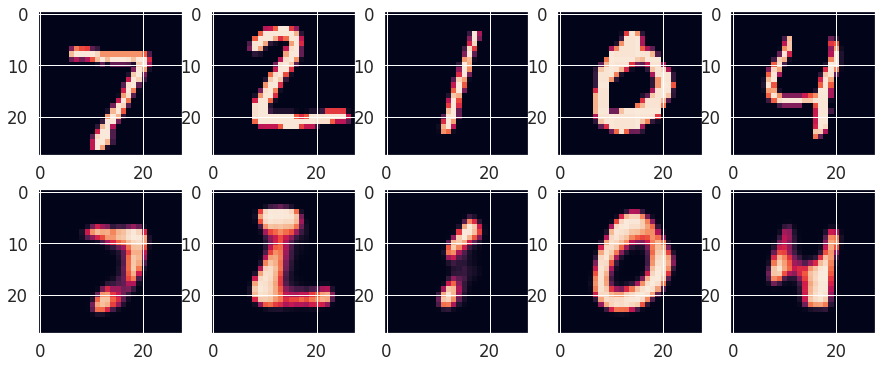

In [8]:
init_idx, n_plots = 0, 5

fig, axes = plt.subplots(2, n_plots, figsize=(3*n_plots, 6))

predictions = oc_vae.predict(x_test[init_idx:init_idx + n_plots])

for i in range(n_plots):
    axes[0][i].imshow(x_test[init_idx + i].squeeze(-1))
    axes[1][i].imshow(predictions[i].squeeze(-1))

fig.show()

Reconstruction weight: 1, KL weight: 0, Centripetal weight: 0
Reconstruction weight: 0.8, KL weight: 0.1, Centripetal weight: 0.1
Reconstruction weight: 0.34, KL weight: 0.33, Centripetal weight: 0.33
Reconstruction weight: 0.2, KL weight: 0.4, Centripetal weight: 0.4
Reconstruction weight: 0.1, KL weight: 0.7, Centripetal weight: 0.2
Reconstruction weight: 0.1, KL weight: 0.7, Centripetal weight: 0.2
Reconstruction weight: 0.1, KL weight: 0.9, Centripetal weight: 0
Reconstruction weight: 0.1, KL weight: 0, Centripetal weight: 0.9
Reconstruction weight: 0.01, KL weight: 0.99, Centripetal weight: 0
Reconstruction weight: 0.01, KL weight: 0, Centripetal weight: 0.99
Reconstruction weight: 0.001, KL weight: 0.999, Centripetal weight: 0
Reconstruction weight: 0.001, KL weight: 0, Centripetal weight: 0.999
Reconstruction weight: 0.0, KL weight: 0.5, Centripetal weight: 0.5
Reconstruction weight: 0.0, KL weight: 0.6, Centripetal weight: 0.4
Reconstruction weight: 0.0, KL weight: 0.9, Centrip

(<Figure size 1080x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1fceb12630>)

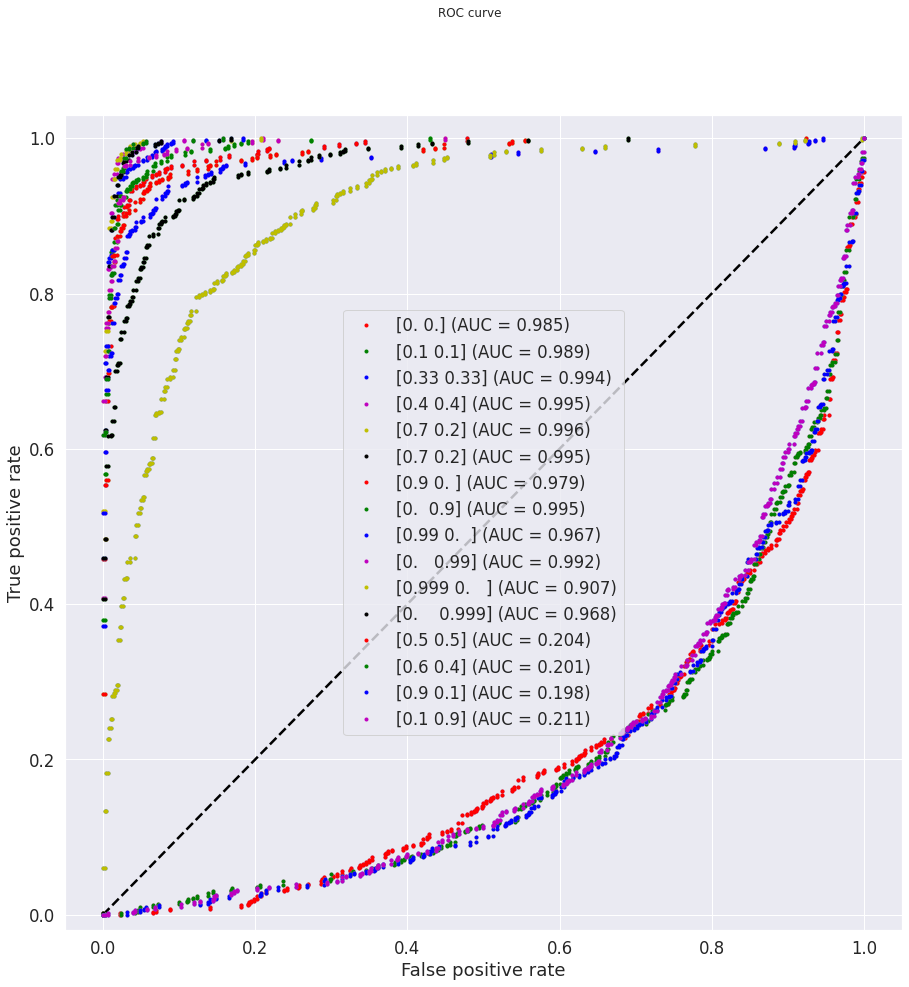

In [ ]:
lambd = [[0, 0],  # reconstrction loss > others
         [0.1, 0.1],
         [0.33, 0.33], # equilibrium
         [0.4, 0.4], # share
         [0.7, 0.2],
         [0.7, 0.2],
         [0.9, 0], # 1 / 2 additional losses
         [0, 0.9],
         [0.99, 0],
         [0, 0.99],
         [0.999, 0],
         [0, 0.999],
         [0.5, 0.5], # no reconstruction loss
         [0.6, 0.4],
         [0.9, 0.1],
         [0.1, 0.9],
         ]

scores = []
fprs, tprs = [], []
for l in lambd:
    print(f"Reconstruction weight: {round(1 - (l[0] + l[1]), 4)}, KL weight: {l[0]}, Centripetal weight: {l[1]}")
    oc_vae = OC_VAE(encoder, decoder, dims=(28,28,1), latent_dims=(4,4,16), LAMBDAS=l)
    oc_vae.compile(optimizer=tf.keras.optimizers.Adam())
    oc_vae.fit(x_train_bin, epochs=30, batch_size=124, verbose=0)
    scores.append(score_samples(oc_vae, x_val, decision_function="reconstruction"))
    fpr, tpr, _ = compute_ROC(y_val_bin, scores[-1], pos_label=1)
    fprs.append(fpr)
    tprs.append(tpr)

plot_ROC(fprs, tprs, labels=lambd)

First value: KL-div coefficient, second value: centripetal loss coefficient and reconstruction loss coefficient: 1 - (KL_coeff + centri coeff).

We observe that, when computing AUC *based on the reconstruction error*:
- if the reconstruction loss is concealed: ((0.5, 0.5), (0.1, 0.9), (0.4, 0.6)...) performances are inversed (?) and the worst of all. => Reconstruction loss is important
- The other losses are also important since (0, 0) has only AUC = 0.9 and (0.1, 0.1) has AUC = .989
- Performances seem to be the best when reconstruction loss has some weight, and the other losses are balanced.

Reconstruction weight: 1, KL weight: 0, Centripetal weight: 0
Reconstruction weight: 0.8, KL weight: 0.1, Centripetal weight: 0.1
Reconstruction weight: 0.34, KL weight: 0.33, Centripetal weight: 0.33
Reconstruction weight: 0.2, KL weight: 0.4, Centripetal weight: 0.4
Reconstruction weight: 0.1, KL weight: 0.7, Centripetal weight: 0.2
Reconstruction weight: 0.1, KL weight: 0.7, Centripetal weight: 0.2
Reconstruction weight: 0.1, KL weight: 0.9, Centripetal weight: 0
Reconstruction weight: 0.1, KL weight: 0, Centripetal weight: 0.9
Reconstruction weight: 0.01, KL weight: 0.99, Centripetal weight: 0
Reconstruction weight: 0.01, KL weight: 0, Centripetal weight: 0.99
Reconstruction weight: 0.001, KL weight: 0.999, Centripetal weight: 0
Reconstruction weight: 0.001, KL weight: 0, Centripetal weight: 0.999
Reconstruction weight: 0.0, KL weight: 0.5, Centripetal weight: 0.5
Reconstruction weight: 0.0, KL weight: 0.6, Centripetal weight: 0.4
Reconstruction weight: 0.0, KL weight: 0.9, Centrip

(<Figure size 1080x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1fd233dbe0>)

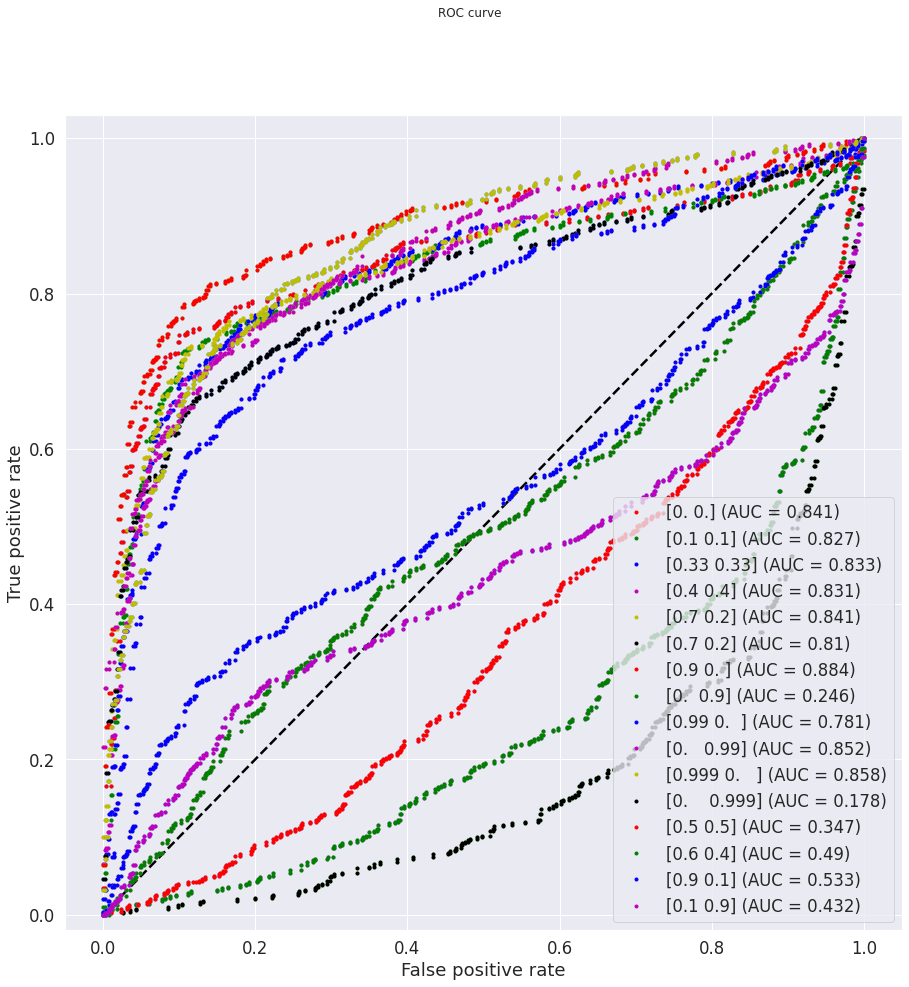

In [ ]:
lambd = [[0, 0],  # reconstrction loss > others
         [0.1, 0.1],
         [0.33, 0.33], # equilibrium
         [0.4, 0.4], # share
         [0.7, 0.2],
         [0.7, 0.2],
         [0.9, 0], # 1 / 2 additional losses
         [0, 0.9],
         [0.99, 0],
         [0, 0.99],
         [0.999, 0],
         [0, 0.999],
         [0.5, 0.5], # no reconstruction loss
         [0.6, 0.4],
         [0.9, 0.1],
         [0.1, 0.9],
         ]

scores = []
fprs, tprs = [], []
for l in lambd:
    print(f"Reconstruction weight: {round(1 - (l[0] + l[1]), 4)}, KL weight: {l[0]}, Centripetal weight: {l[1]}")
    oc_vae = OC_VAE(encoder, decoder, dims=(28,28,1), latent_dims=(4,4,16), LAMBDAS=l)
    oc_vae.compile(optimizer=tf.keras.optimizers.Adam())
    oc_vae.fit(x_train_bin, epochs=30, batch_size=124, verbose=0)
    scores.append(score_samples(oc_vae, x_val, decision_function="distance"))
    fpr, tpr, _ = compute_ROC(y_val_bin, scores[-1], pos_label=1)
    fprs.append(fpr)
    tprs.append(tpr)

plot_ROC(fprs, tprs, labels=lambd)

Performances are a lot worse when computing a latent-distance based AUC than with the reconstruction loss-based AUC. 
- Here the reconstruction loss still has impact on AUC, and is required for having a good score (see (0.6, 0.4), (0.9, 0.1)...). It was not obvious a priori, since reconstruction quality is not directly used to compute the score (it's in this case only an objective function during training). We conclude from this observation that aiming to have a low reconstruction error can lead to having a well structured latent space (?)
- Surprisingly, the best score is achieved with only the VAE loss configuration (0.9, 0.1)